In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

print("Running on PyMC3 v{}".format(pm.__version__))
print("Running on arviz v{}".format(az.__version__))

Running on PyMC3 v5.7.2
Running on arviz v0.16.0


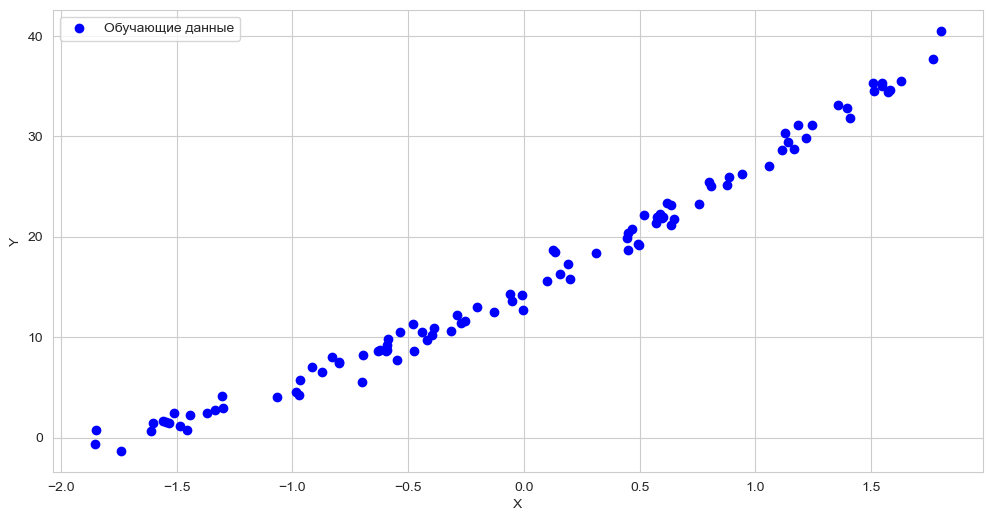

In [4]:
train = pd.read_csv('regression/train_reg.csv')
test = pd.read_csv('regression/test_reg.csv')

X_train = train[['x']]
y_train = train[['y']]
X_test = test[['x']]

# Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.scatter(X_train, y_train, label='Обучающие данные', color='b')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

Видно, что данные тут описываются квадратичной функцией, но и линейная сойдет

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.
/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behav

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,16.195,0.176,15.867,16.533,0.002,0.001,12566.0,6223.0,1.0
β,10.538,0.179,10.191,10.867,0.002,0.001,10111.0,5411.0,1.0
ε,1.725,0.127,1.498,1.960,0.001,0.001,9225.0,6322.0,1.0


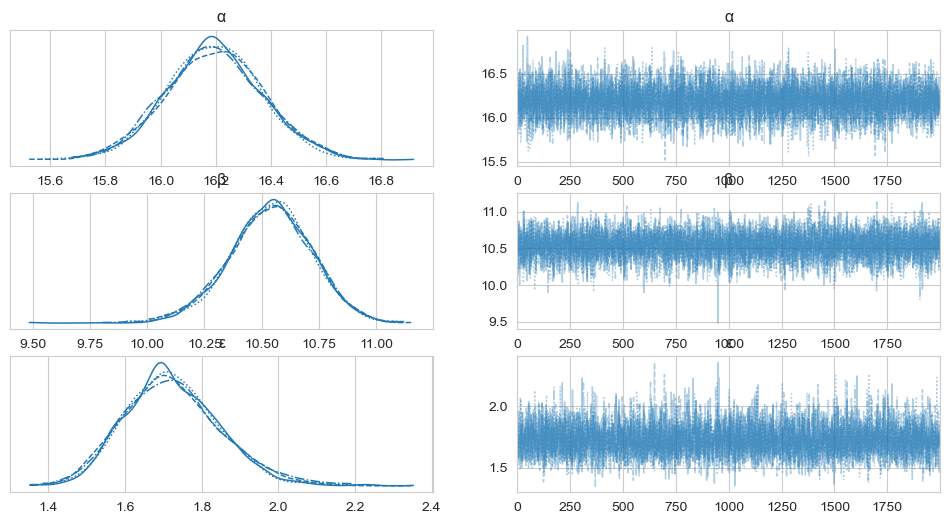

In [5]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    ε = pm.HalfNormal('ε', 10)
    μ = pm.Deterministic('μ', α + β * X_train)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=y_train)
    trace_g = pm.sample(2000, tune=2000, chains=4, cores=4)

az.plot_trace(trace_g, var_names=['α', 'β', 'ε']);
az.summary(trace_g).head(3)

всего трасс :  8000


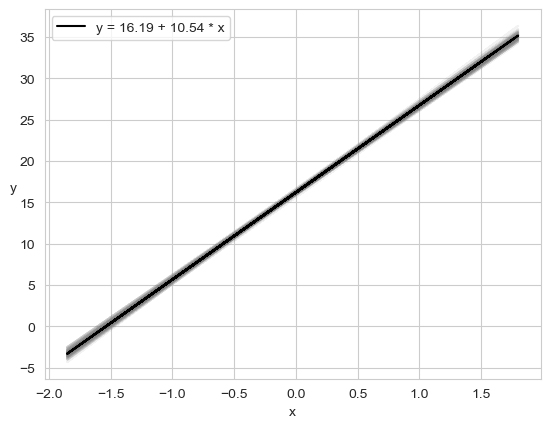

In [6]:
posterior_g = az.extract(trace_g)

alpha_m = posterior_g['α'].mean().item()
beta_m  = posterior_g['β'].mean().item()

print("всего трасс : ", posterior_g.sample.size)

draws = range(0, posterior_g.sample.size, 100)

plt.plot(X_train, posterior_g['α'][draws].values + posterior_g['β'][draws].values * X_train, c='gray', alpha=0.1)

plt.plot(X_train, alpha_m + beta_m * X_train, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

Посмотрим как работает наша регрессия на тренировочной выборке. Так как нам нужно посчитать конкретные прездсказания и модель у нас линейная, то можно просто взять средние коэффиценты.


In [7]:
y_train_pred = alpha_m + beta_m*X_train
r2 = r2_score(y_train, y_train_pred)
print("R^2 Score:", r2)

R^2 Score: 0.9764324910434686


In [8]:
у_pred = alpha_m + beta_m*X_test

In [9]:
у_pred = у_pred.reshape(100)
у_pred

array([17.49210706,  7.7315976 , -2.23418172, 29.41651082, 21.4208456 ,
       21.96971207, 12.97059401, 25.17813316, 27.84026121,  5.87038214,
        6.55024289, 28.17167115, 21.63895581,  9.90905207, 28.13916255,
       29.9814783 , 17.7160701 , 24.20133685, 17.4687115 ,  5.4036535 ,
       24.51570875,  7.57322   , 23.99453461, 20.96454791, 10.79617402,
        8.13385725, 14.07165739, 14.04093121, 21.53426457, 23.9115454 ,
        2.28377746,  1.74974409,  8.65912983, 11.50169721, 21.13316572,
       21.03950133, 21.53963001, 20.61832975, 28.42836347,  6.76222691,
        7.94826601, 38.0314902 ,  8.55778018,  1.58179369, 20.65186899,
       33.36600017,  2.89486465,  1.72576206, 25.13511809, 15.55048563,
       17.74959002, 24.9619367 , -0.55492075, 21.06410321, 11.16830321,
       12.22090739, 20.29540486, 18.23119805, 29.22991259, 14.4854367 ,
       27.8973362 , 17.08711989,  3.12193331,  2.22128968,  6.86169176,
       13.58147573,  4.53360341, 33.81977457, 15.60451311, 22.74

In [10]:
from sklearn.metrics import mean_squared_error
y_true = pd.read_csv('test_Y_true_reg.csv')
mean_squared_error(y_true, у_pred)

2.5112449138172668